In [2]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm
import random 

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)

import matplotlib.pyplot as plt


class ExampleMDP(object):
    
    """
    MDP Overview:
    
        N(-0.1, 1)
    T      <---                 start              T
    0      <---    1     <---     2     --->      3
           <---           a=0           a=1
    """
    
    def __init__(self, mean=-0.1):
        
        self.P = {0 : {0 : (1.0, 0, 0.0, True),
                       1 : (1.0, 0, 0.0, True)
                      },
                  1 : {i : (1.0, 0, np.random.normal(mean, 1), False) for i in range(100)
                      },
                  2 : {0 : (1.0, 1, 0.0, False),
                       1 : (1.0, 3, 0.0, False)
                      },
                  3 : {0 : (1.0, 3, 0.0, True),
                       1 : (1.0, 3, 0.0, True)
                      }
                 }
        
        self.nA = 2
        self.nS = 4
        # return current state
        self.cS = None
        
    def reset(self):
        self.cS = 2 # Always start in 2
        return self.cS
    
    def step(self, action):
        
        if self.cS == 1:
            action = random.choice([i for i in range(100)])
        
        probability, next_state, reward, done = self.P[self.cS][action]
        
        # produce new reward if in state 1:
        #if self.cS == 1:
            #reward = np.random.normal(-0.1, 1)    
        
        self.cS = next_state
        
        return next_state, reward, done, {'prob' : probability}

In [3]:
env = ExampleMDP()
state = env.reset()
print('Home:\t\t', state)
# go left = 0
# go right = 1
state = env.step(1)
print('To right:\t', state)

state = env.reset()
print('Reset:\t\t', state)
state = env.step(0)
print('To left:\t', state)
state = env.step(0)
print('To left:\t', state)

Home:		 2
To right:	 (3, 0.0, False, {'prob': 1.0})
Reset:		 2
To left:	 (1, 0.0, False, {'prob': 1.0})
To left:	 (0, -1.9318046252531247, False, {'prob': 1.0})


In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = (np.zeros(env.nA) + epsilon) / env.nA
        
        if np.count_nonzero(Q[observation]) == 0:
            best = np.random.choice(range(env.nA))
        else:
            best = np.argmax(Q[observation])
        
        A[best] += (1.0 - epsilon)
        
        return A
        
    return policy_fn

def make_epsilon_greedy_double_q_policy(Q1, Q2, epsilon, nA):
    
    def policy_fn(observation):
        
        Q_add = defaultdict(lambda: np.zeros(env.nA))
    
        for key1, value1 in Q1.items():
        
            for key2, value2 in Q2.items():
            
                if key1 == key2:
                
                    Q_add[key1] = value1 + value2
        
        A = (np.zeros(env.nA) + epsilon) / env.nA

        if np.count_nonzero(Q_add[observation]) == 0:
            best = np.random.choice(range(env.nA))
        else:
            best = np.argmax(Q_add[observation])
        
        A[best] += (1.0 - epsilon)
        return A
        
    return policy_fn

In [5]:
def q_learning(env, num_episodes, mean=-0.1, discount_factor=1.0, alpha=0.1, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.nA))
    
    # Keeps track of useful statistics
    stats = []
    action_left = 0

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.nA)
    
    for i_episode in range(num_episodes):
        #i = 0
        R = 0

        current_state = env.reset()
        action_probs = policy(current_state) 
        current_action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        if current_action == 0:
            action_left += 1

        while True:
            
            next_state, reward, done, _ = env.step(current_action)
            next_A = policy(next_state)

            next_action = np.random.choice(range(env.nA), p=next_A)
            
            target = reward + (discount_factor * max(Q[next_state]) - Q[current_state][current_action])
            Q[current_state][current_action] += alpha * target
            
            #i += 1
            R += reward
            
            current_state, current_action = next_state, next_action
            
            if done:
                break

        stats.append((action_left / (i_episode+1), i_episode))
    return Q, zip(*stats)

In [6]:
def double_q_learning(env, num_episodes, mean=-0.1, discount_factor=1.0, alpha=0.1, epsilon=0.1, Q1=None, Q2=None):
    """
    Double Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
        
    if Q1 is None:
        Q1 = defaultdict(lambda: np.zeros(env.nA))
    if Q2 is None:
        Q2 = defaultdict(lambda: np.zeros(env.nA))
    
    # Keeps track of useful statistics
    stats = []
    action_left = 0

    # The policy we're following    
    policy = make_epsilon_greedy_double_q_policy(Q1, Q2, epsilon, env.nA)
    
    #Keep track of which update function we use, we alternate between 1/2
    turn1 = random.choice([True, False])
    
    for i_episode in range(num_episodes):
        R = 0
        current_state = env.reset()
        action_probs = policy(current_state) 
        current_action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        if current_action == 0:
            action_left += 1
            
        done = False

        while not done:
            
            next_state, reward, done, _ = env.step(current_action)
            next_A = policy(next_state)
            next_action = np.random.choice(range(env.nA), p=next_A)
            
            if turn1:
                target = reward + discount_factor * (Q2[next_state][np.argmax(Q1[next_state])] - Q1[current_state][current_action])
                Q1[current_state][current_action] += alpha * target
            else:
                target = reward + discount_factor * (Q1[next_state][np.argmax(Q2[next_state])] - Q2[current_state][current_action])
                Q2[current_state][current_action] += alpha * target
                
            R += reward
            
            #print(i_episode, Q1, Q2)
            
            current_state, current_action = next_state, next_action
            
            #Switch turns
            turn1 = random.choice([True, False])
    
        stats.append((action_left / (i_episode+1), i_episode))
        
    return Q1, Q2, zip(*stats)

In [7]:
def weighted_double_q_learning(env, num_episodes, c=1.0, discount_factor=1.0, alpha=0.1, epsilon=0.1, Q1=None, Q2=None):
    """
    Weighted Double Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        c: Weighting factor
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q1 is None:
        Q1 = defaultdict(lambda: np.zeros(env.nA))
    if Q2 is None:
        Q2 = defaultdict(lambda: np.zeros(env.nA))
    
    # Keeps track of useful statistics
    stats = []
    action_left = 0

    # The policy we're following    
    policy = make_epsilon_greedy_double_q_policy(Q1, Q2, epsilon, env.nA)
    
    #Keep track of which update function we use, we alternate between 1/2
    turn1 = random.choice([True, False])
    
    #Keep track of which update function we use, we alternate between 1/2
    turn1 = random.choice([True, False])
    
    for i_episode in range(num_episodes):
        R = 0
        current_state = env.reset()
        action_probs = policy(current_state) 
        current_action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        if current_action == 0:
            action_left += 1
            
        done = False

        while not done:
            next_state, reward, done, _ = env.step(current_action)
            next_A = policy(next_state)
            next_action = np.random.choice(range(env.nA), p=next_A)
                        
            if turn1:
                a_star = np.argmax(Q1[next_state])
                a_L = np.argmin(Q1[next_state])
                beta = abs(Q2[next_state][a_star] - Q2[next_state][a_L]) / (c + abs(Q2[next_state][a_star] - Q2[next_state][a_L]))
            
                target = reward + discount_factor * ( (beta * Q1[next_state][a_star]) + ((1 - beta) * Q2[next_state][a_star]))- Q1[current_state][current_action]
                Q1[current_state][current_action] += alpha * target
            else:
                a_star = np.argmax(Q2[next_state])
                a_L = np.argmin(Q2[next_state])
                beta = abs(Q1[next_state][a_star] - Q1[next_state][a_L]) / (c + abs(Q1[next_state][a_star] - Q1[next_state][a_L]))
                
                target = reward + discount_factor * ( (beta * Q2[next_state][a_star]) + ((1 - beta) * Q1[next_state][a_star]))- Q2[current_state][current_action]
                Q2[current_state][current_action] += alpha * target
                
            R += reward
            
            #print(i_episode, Q1, Q2)
            
            current_state, current_action = next_state, next_action
            
            #Switch turns
            turn1 = random.choice([True, False])
            
        stats.append((action_left / (i_episode+1), i_episode))
        
    return Q1, Q2, zip(*stats)

In [8]:
RUNS = 1000
EPISODES = 300

q_data = np.zeros((RUNS, EPISODES))
dq_data = np.zeros((RUNS, EPISODES))
wdq_1_data = np.zeros((RUNS, EPISODES))
wdq_10_data = np.zeros((RUNS, EPISODES))
wdq_100_data = np.zeros((RUNS, EPISODES))

for i in tqdm(range(RUNS)):
    _, (left_ratio, episode_nr) = q_learning(env, EPISODES)
    q_data[i, :] = left_ratio
    
    _,_, (left_ratio, episode_nr) = double_q_learning(env, EPISODES)
    dq_data[i, :] = left_ratio
    
    _,_, (left_ratio, episode_nr) = weighted_double_q_learning(env, EPISODES, c=1)
    wdq_1_data[i, :] = left_ratio
    
    _,_, (left_ratio, episode_nr) = weighted_double_q_learning(env, EPISODES, c=10)
    wdq_10_data[i, :] = left_ratio
    
    _,_, (left_ratio, episode_nr) = weighted_double_q_learning(env, EPISODES, c=100)
    wdq_100_data[i, :] = left_ratio

  0%|          | 4/1000 [00:04<17:42,  1.07s/it]


KeyboardInterrupt: 

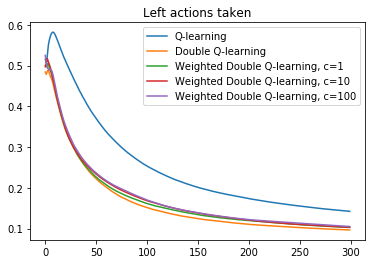

In [9]:
# Plot percentage actions left over episodes:
plt.plot(q_data.mean(0), label='Q-learning')
plt.plot(dq_data.mean(0), label='Double Q-learning')
plt.plot(wdq_1_data.mean(0), label='Weighted Double Q-learning, c=1')
plt.plot(wdq_10_data.mean(0), label='Weighted Double Q-learning, c=10')
plt.plot(wdq_100_data.mean(0), label='Weighted Double Q-learning, c=100')
plt.title('Left actions taken')
plt.xlabel('Number of episodes')
plt.ylabel('Number of steps to complete episode')
plt.legend()
plt.show()

In [9]:
RUNS = 1000
EPISODES = 300
means = [-0.5, -0.1, -.01]
number_of_means = len(means)

q_data = np.zeros((number_of_means, RUNS, EPISODES))
dq_data = np.zeros((number_of_means, RUNS, EPISODES))

for i in tqdm(range(RUNS)):
    for j in range(len(means)):
        env = ExampleMDP(mean=means[j])
        _, (left_ratio, episode_nr) = q_learning(env, EPISODES)
        q_data[j, i, :] = left_ratio

        _,_, (left_ratio, episode_nr) = double_q_learning(env, EPISODES)
        dq_data[j, i, :] = left_ratio
            

100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]


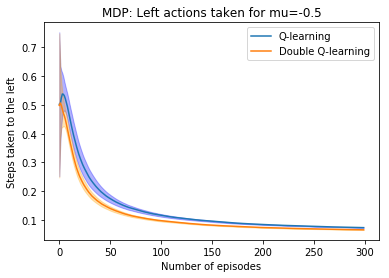

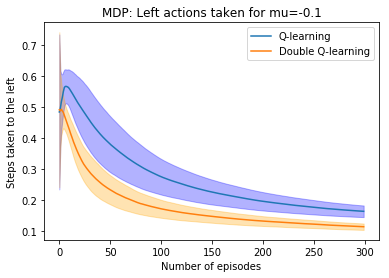

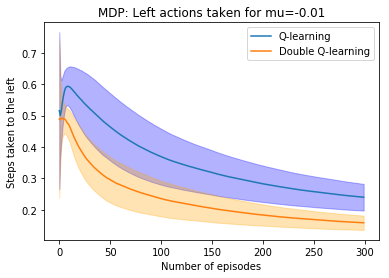

In [13]:
x = np.arange(0,300,1)

for j in range(len(means)):
    # Plot percentage actions left over episodes:
    plt.plot(q_data[j].mean(0), label='Q-learning')
    plt.fill_between(x, q_data[j].mean(0) + q_data[j].var(0), q_data[j].mean(0) - q_data[j].var(0), color='blue', alpha=0.3)

    plt.plot(dq_data[j].mean(0), label='Double Q-learning')
    plt.fill_between(x, dq_data[j].mean(0) + dq_data[j].var(0), dq_data[j].mean(0) - dq_data[j].var(0), color='orange', alpha=0.3)
#     plt.plot(dq_data[j].mean(0) + dq_data[j].std(0))
#     plt.plot(dq_data[j].mean(0) - dq_data[j].std(0))
    plt.title('MDP: Left actions taken for mu={}'.format(means[j]))
    plt.xlabel('Number of episodes')
    plt.ylabel('Steps taken to the left')
    plt.legend()
    plt.show()

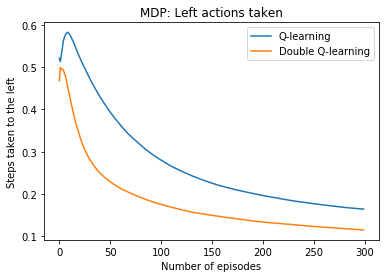

In [44]:
plt.plot(q_data[3].mean(0), label='Q-learning')
plt.plot(dq_data[3].mean(0), label='Double Q-learning')
plt.title('MDP: Left actions taken'.format(means[j]))
plt.xlabel('Number of episodes')
plt.ylabel('Steps taken to the left')
plt.legend()
plt.show()